In [1]:
#Загружаем текст
import os
import scipy as sp
import time
import math
from scipy.sparse import dok_matrix, \
                         lil_matrix, \
                         coo_matrix, \
                         csr_matrix

from collections import defaultdict
with open(f'filimdb_evaluation/FILIMDB/train.texts', 'r') as f:
    text = f.read()
train=[review for review in text.split('\n')]

with open(f'filimdb_evaluation/FILIMDB/train.labels', 'r') as f:
    text_labels = f.read()
labels=[1 if label=="pos" else 0  for label in text_labels.split('\n')]

#Скачиваем валидационую выборку     #######################################################################
from collections import defaultdict
with open(f'filimdb_evaluation/FILIMDB/dev.texts', 'r') as f:
    text = f.read()
develop=[review for review in text.split('\n')]

with open(f'filimdb_evaluation/FILIMDB/dev.labels', 'r') as f:
    text_labels = f.read()
labels_develop=[1 if label=="pos" else 0  for label in text_labels.split('\n')]    ##################

In [2]:
def preprocessing(my_text):
    #Переводим в нижний регистр
    #Уберём все лишние символы(не буквы и цифры) Просто удалил все лишние символы
    return ''.join([symbol.lower()  for symbol in my_text if symbol.isalnum() or symbol==' '])

In [3]:
def tokenization(my_text):
    return [word for word in my_text.split(' ') if not word==' 'and not word=='  ' and not word=='']

In [4]:
# предобработка и токенизация Обучающей выборки
train=[tokenization(preprocessing(review)) for review in train]

In [5]:
# предобработка и токенизация Валидационой выборки                     ####################################
develop=[tokenization(preprocessing(review)) for review in develop]    ####################################

In [6]:
# Постройте словарь, в котором будут содержаться все уникальные
# токены из обучающей выборки.
train_dict=defaultdict(int)
k=0;
for review in train:
    for token in review:
        if not token in train_dict:
            train_dict[token]=k
            k+=1
            
train_dict['<unk>']=k
M=len(train_dict)
N=len(train)-1
train_dict_list=list(train_dict.keys())
# Длина получившегося словаря: 93043

In [8]:
# Для того, чтобы обучить логистическую регрессию необходимо представить обучаю-
# щую и тестовую выборки в виде матриц размера N ∗ V , где N – количество отзывов
# в выборке, а V – размер словаря.
def sparse_performance(N,M,train,train_dict):
    train_dict_list=list(train_dict.keys())
    data =[]  # Non-zero elements
    row =[] # their row indices
    col =[]  # their column indices
#Эта функция работает не только с обучающей воборкой, а для любой , если задан словарь.
# indx=0
    for i in range(N):#Проходимся по всем отзывам
#     start_time = time.time()
#     indx+=1
        dev=train[i]
        dev.sort()# сортируем их для удобства
        k=0
        helpser=dev[0]
        for j in dev:#считаем вхождения
        
            if j==helpser:
                k+=1
            else:
                data.append(k)
                row.append(i)
                k=1
                helpser=j
                if helpser in train_dict:
                    col.append(train_dict[helpser])# супер проблемная строчка, долго ищет!!(исправил)
                else:
                    col.append(train_dict['<unk>'])
                    
    X = csr_matrix((data, (row, col)), shape=(N, M))
    return X
#     print("--- %s seconds ---\n" % (time.time() - start_time))
#     print(indx,'\n')


#     le=len(train[i])
#     for j in range(len(train_dict_list)):
#         if train_dict_list[j] in train[i]:
#             dev=train[i].count(train_dict_list[j])
#             data.append(dev)
#             row.append(i)
#             col.append(j)
#             le-=dev
            
#     if not le==0:
#         data.append[le]
#         row.append(i)
#         col.append(train_dict_list.index('<unk>'))
        
            
    
                
        


In [12]:
X = sparse_performance(N,M,train,train_dict)
X.shape

(15000, 93043)

In [13]:
DEV=sparse_performance(len(develop)-1,M,develop,train_dict)

In [14]:
# Напишите функцию сигмоида (покомпонентная)
import numpy as np
def sigmoida (arg):
    arg=np.array(arg)
    shp=arg.shape
    c=1
    for i in range(len(shp)):
    	c=c*shp[i]
    arg=arg.reshape(c,)
    return  1/(1+np.exp(-arg)) if shp==() else np.array([ math.fabs(1/(1+np.exp(-i))-1e-7) if 1/(1+np.exp(-i))==0.0 or 1/(1+np.exp(-i))==1.0 else 1/(1+np.exp(-i)) for i in arg] ).reshape(shp)
# math.fabs(1/(1+np.exp(-i))-1e-7) if 1/(1+np.exp(-i))==0.0 or 1/(1+np.exp(-i))==1.0 else 1/(1+np.exp(-i))
#Делаю проверку на те случаи, когда сигмоида выдаёт либо 0, либо 1.В таком случае чуть отступаю в сторонку=)
def logs (arg):
    arg=np.array(arg)
    shp=arg.shape
    c=1
    for i in range(len(shp)):
    	c=c*shp[i]
    arg=arg.reshape(c,)
    return  math.log(arg) if shp==() else np.array([math.log(i) for i in arg]).reshape(shp)

In [15]:
# Напишите функцию инициализации весов
# (принимает число признаков, возвращает вектор нулей нужного типа и размера).
def initialization (N):
    return np.zeros((1,N+1), dtype=float)

In [16]:
# Прямой проход. Напишите две функции, которые для заданной выборки (матрица
# векторов признаков X, вектор правильных ответов y), вектора весов w и значения ги-
# перпараметра α вычисляют оценочную фунцию и точность: одну с использованием цик-
# ла по примерам, другую - без цикла, с помощью матричных операций

def BCE_plus_reg(X,y,w,a):
    n,m = X.shape # for generality
    X0= np.ones((n,1))
    X=sp.sparse.hstack((X0,X))#Добавили столбец для bias
    scalar=np.array(X.dot(w.T))#Посчиталь скаляр
   
    sig=sigmoida(scalar)#Посчиталь функцию активациии
    L=-(1/n)*((y).dot(logs(sig)) +(1-y).dot(logs(1-sig)))+a*w.dot(w.T)
    sig=sig.reshape(n,)
    y=y.reshape(n,)
    accuracy_dev=np.array([1 if sig[i]>0.5 else 0  for i in range(len(sig))])
    accuracy=0
    for i in range(len(sig)):
        if accuracy_dev[i]==y[i]:
            accuracy+=1
    accuracy=accuracy/n
    return L[0][0],accuracy
# Как и было аналитически посчитано, эта функция при нулевых весах выдаёт значение логарифма
# в точке 1/2 с минусом, а точность примерно 0,5!!!(0.6931471805599455 0.49866666666666665)

In [20]:
# Прямой+обратный проход. Напишите функцию, которая для заданной выборки
# (матрица векторов признаков X, вектор правильных ответов y), вектора весов w и
# значения гиперпараметра α возвращает точность классификатора, значение оценочной
# функции L и ее градиенты

def forward_and_reverse(X,y,w,a):
    n,m = X.shape # for generality
    X0= np.ones((n,1))
    X=sp.sparse.hstack((X0,X))#Добавили столбец для bias
    scalar=np.array(X.dot(w.T))#Посчиталь скаляр
    sig=sigmoida(scalar)#Посчиталь функцию активациии
    L=-(1/n)*((y).dot(logs(sig)) +(1-y).dot(logs(1-sig)))+a*w.dot(w.T)
    sig=sig.reshape(n,)
    y=y.reshape(n,)
    gradient=(sp.sparse.diags(sig-y)).dot(X)#Считаем градиент матричными формулами=)
    gradient=np.sum(gradient,axis=0)
    gradient=gradient/n+2*a*w
    accuracy_dev=np.array([1 if sig[i]>0.5 else 0  for i in range(len(sig))])#СЧитаем точность
    accuracy=0
    for i in range(len(sig)):
        if accuracy_dev[i]==y[i]:
            accuracy+=1
    accuracy=accuracy/n
    return L,accuracy,gradient
    

In [21]:
#Напишите функцию, которая используя посчитанные градиен-
#ты, делает шаг градиентного спуска (обновляет значение весов)
def descent_step (w,gradient,learning_rate):
    return w-learning_rate*gradient

In [22]:
# Градиентный спуск.Напишите функцию,
# которая принимает обучающую выборку, текущие значения весов, число эпох обучения,
# learning rate, обучает модель методом градиентного спуска и возвращает новые значе-
# ния весов.
def gradient_descent(X,w,epoch,learning_rate,y,a,DEV,y_dev):
    graphics_t=[]#Сoхраним данные для построения графика
    L_t=[]
    accuracy_t=[]
    epoch_t=[]
    
    graphics_v=[]
    L_v=[]
    accuracy_v=[]
    epoch_v=[]
    for i in range(epoch):
        L,accuracy,gradient=forward_and_reverse(X,y,w,a)
        L_t.append(float(L))
        accuracy_t.append(accuracy)
        epoch_t.append(i)
        
#       Посчитаем точность на валидационной выборке
        L,accuracy=BCE_plus_reg(DEV,y_dev,w,a)
        L_v.append(float(L))
        accuracy_v.append(accuracy)
        epoch_v.append(i)
        
#       Конец подсчёта   
        w=descent_step(w,gradient,learning_rate)
    graphics_v.append(L_v)
    graphics_v.append(accuracy_v)
    graphics_v.append(epoch_v)
    
    graphics_t.append(L_t)
    graphics_t.append(accuracy_t)
    graphics_t.append(epoch_t)
    return w,graphics_t,graphics_v

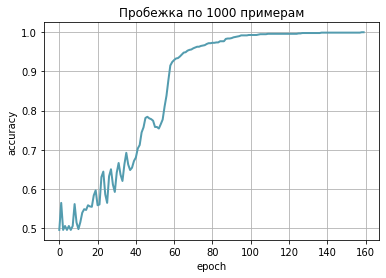

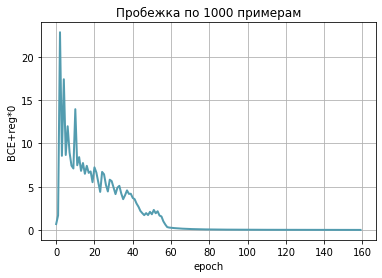

In [74]:
import matplotlib.pyplot as plt
# Для тестирования отключите регуляризацию ( α = 0) и проверьте, что классификатор
# может запомнить небольшую часть (1000 примеров) обучающей выборки (точность на
# ней должна быть равна 1.0, потребуется подобрать learning rate и число эпох обуче-
# ния).
w=initialization(M)
a=0
y=np.array(labels[:-1]).reshape(1,15000)
lamda=1
epoch=160
w,graph=gradient_descent(X[:1000],w,epoch,lamda,y[0][:1000],a)
_,ax = plt.subplots()
ax.plot(graph[2], graph[1], lw = 2, color = '#539caf', alpha = 1)
ax.set_title('Пробежка по 1000 примерам')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.grid(True)

_,ay = plt.subplots()
ay.plot(graph[2], graph[0], lw = 2, color = '#539caf', alpha = 1)
ay.set_title('Пробежка по 1000 примерам')
ay.set_xlabel('epoch')
ay.set_ylabel('BCE+reg*0')
ay.grid(True)

plt.show()
#Здесь функция градиентного спуска ещё не изменена, поэтому не может принимать на вход валидационную выборку.

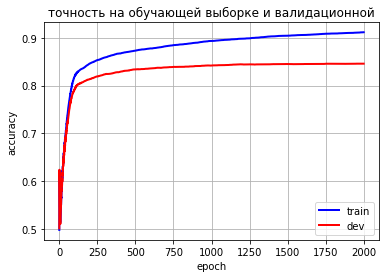

Итоговая точность на обучающей:		  0.9112 % 

Итоговая точность на валидационной:		  0.8456 % 



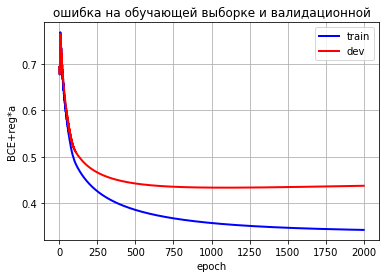

In [51]:
import matplotlib.pyplot as plt
# Установите learning rate равным 1e−3, коэффициент L 2 регуляризации α равным 1e−5.
# Обучите логистическую регрессию на обучающей выборке. Постройте графики измене-
# ния оценочной функции и точности на обучающей и валидационной выборках в процессе
# обучения (графики обучения).
lamda=5e-2
a=4e-3
w=initialization(M)
y=np.array(labels[:-1]).reshape(1,15000)
y_dev=np.array(labels_develop[:-1]).reshape(1,10000)
epoch=2000
w,graph_t,graph_v=gradient_descent(X,w,epoch,lamda,y,a,DEV,y_dev)
#Графика
plt.plot(graph_t[2], graph_t[1], lw = 2, color = 'blue',alpha = 1 ,label='train')
plt.plot(graph_v[2], graph_v[1], lw = 2, color = 'red', alpha = 1, label='dev')
plt.title('точность на обучающей выборке и валидационной')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(loc='best')
plt.show()

print("Итоговая точность на обучающей:\t\t ",graph_t[1][-1],"% \n")
print("Итоговая точность на валидационной:\t\t ",graph_v[1][-1],"% \n")


plt.plot(graph_t[2], graph_t[0], lw = 2, color = 'blue', alpha = 1 ,label='train')
plt.plot(graph_v[2], graph_v[0], lw = 2, color = 'red', alpha = 1, label='dev')
plt.title('ошибка на обучающей выборке и валидационной')
plt.ylabel('BCE+reg*a')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(loc='best')
plt.show()
#Конец графики

Удалось достичь точности в  0.9112 % на обучающей и 0.8456 % на валидационной на 2000 эпохах.Переобучения не происходит, всё тихо-мирно